# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [71]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import NormalPredictor
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVDpp
from surprise.accuracy import rmse, mae
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import numpy

In [2]:
artist_data = pd.read_csv("./data/lastfm/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [3]:
user_artist_plays = pd.read_csv("./data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [6]:
# ¿Cuáles son los artistas que fueron más escuchados?
user_artist_plays_top_10 = user_artist_plays.sort_values(by='weight', ascending=False).head(10)
user_artist_plays_top_10.join(artist_data.set_index('id'), on='artistID')['name']

72739          Depeche Mode
91659                Thalía
49304                    U2
84249                  Blur
73745              Paramore
51458           Evanescence
23731    Christina Aguilera
87611               Shakira
34716               Shakira
48898             Glee Cast
Name: name, dtype: object

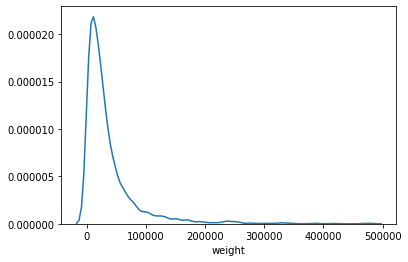

In [14]:
# ¿Cómo es la distribución de cantidad de listens por user?
import seaborn as sns
data = user_artist_plays.groupby('userID')['weight'].sum()
sns.distplot(data, rug=False, hist=False)


In [15]:
user_artist_plays.groupby('userID')['weight'].sum().describe()

count      1892.000000
mean      36566.582981
std       48744.552394
min           3.000000
25%        9742.250000
50%       21573.000000
75%       42963.750000
max      480039.000000
Name: weight, dtype: float64

In [16]:
# ¿Es posible ver el género más escuchado?
tags = pd.read_csv("./data/lastfm/tags.dat", sep="\t", encoding='latin-1')
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [17]:
# podemos suponr que los tagValue con generos.
user_taggedartists = pd.read_csv("./data/lastfm/user_taggedartists.dat", sep="\t")
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [18]:
# artista mas escuchado
user_artist_plays[user_artist_plays['weight'] == user_artist_plays['weight'].max()]

,userID,artistID,weight
72739,1642,72,352698


In [19]:
# tags que le han asignado a ese artista los usuarios
user_taggedartists[user_taggedartists['artistID'] == 72]['tagID']

107       18
444       18
2241      61
2511      16
2512      18
          ..
185323    16
185324    17
185325    18
185326    74
185690    74
Name: tagID, Length: 701, dtype: int64

In [20]:
# tagValue de los tags asignados a ese artista po los usuarios
tagValues = tags[tags['tagID'].isin(user_taggedartists[user_taggedartists['artistID'] == 72]['tagID'])]['tagValue']

In [21]:
# tagValue
tagValues

0                                                 metal
2                                             goth rock
8                                    electro-industrial
12                                             chillout
13                                              ambient
                              ...                      
10492                         stuff that gets me moving
10493    holy fucking shit this shit is fucking awesome
10501                   essential instrumental versions
11375                                          tinosoft
11548                             new wave and eighties
Name: tagValue, Length: 260, dtype: object

In [22]:
# Conclusion, vemos que hay algunos generos. se puede listar los tagsID qu son generos y de ahi poder disciminar mejor.

## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [27]:
matrix = pd.pivot_table(user_artist_plays, values=['weight'], index=['userID'], columns=['artistID'], fill_value=0, dropna=False)

In [28]:
matrix.shape

(1892, 17632)

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [46]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
weight_norm = min_max_scaler.fit_transform(user_artist_plays.weight.values.reshape(-1, 1))
user_artist_plays['weight_norm'] = weight_norm
user_artist_plays.head()

,userID,artistID,weight,weight_norm
0,2,51,13883,0.039360
1,2,52,11690,0.033142
2,2,53,11351,0.032181
3,2,54,10300,0.029201
4,2,55,8983,0.025467


In [47]:
reader = Reader(rating_scale=(numpy.amin(user_artist_plays_norm), 
                              numpy.amax(user_artist_plays_norm)))
data = Dataset.load_from_df(user_artist_plays[['userID', 'artistID', 'weight_norm']], reader)

In [58]:
history = []

In [59]:
ratings_train, ratings_test = train_test_split(data, test_size=0.2)
model = NormalPredictor().fit(ratings_train)
predictions = model.test(ratings_test)
history.append({'algo':'NormalPredictor', 'rmse':rmse(predictions, verbose=False)})
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

RMSE on test: 0.0116


In [60]:
ratings_train, ratings_test = train_test_split(data, test_size=0.2)
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items (item-based collaborative filtering).
                                    # Dados dos items similares i y j y un usuario u que adquirió i le recomendamos j.
               }
model = KNNWithMeans(sim_options=sim_options).fit(ratings_train)
predictions = model.test(ratings_test)
history.append({'algo':'KNNWithMeans', 'rmse':rmse(predictions, verbose=False)})
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0106


In [61]:
ratings_train, ratings_test = train_test_split(data, test_size=0.2)
sim_options = {'name': 'pearson',
               'user_based': False  # compute  similarities between items
               }
model = KNNWithMeans(sim_options=sim_options).fit(ratings_train)
predictions = model.test(ratings_test)
history.append({'algo':'KNNWithMeans', 'rmse':rmse(predictions, verbose=False)})
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0126


In [62]:
ratings_train, ratings_test = train_test_split(data, test_size=0.2)
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
model = KNNWithZScore(sim_options=sim_options).fit(ratings_train)
predictions = model.test(ratings_test)
history.append({'algo':'KNNWithZScore_cosine', 'rmse':rmse(predictions, verbose=False)})
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0092


In [63]:
ratings_train, ratings_test = train_test_split(data, test_size=0.2)
sim_options = {'name': 'pearson',
               'user_based': False  # compute  similarities between items
               }
model = KNNWithZScore(sim_options=sim_options).fit(ratings_train)
predictions = model.test(ratings_test)
history.append({'algo':'KNNWithZScore_pearson', 'rmse':rmse(predictions, verbose=False)})
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0120


In [64]:
history

[{'algo': 'NormalPredictor', 'rmse': 0.011609194329778258},
 {'algo': 'KNNWithMeans', 'rmse': 0.010629282647060014},
 {'algo': 'KNNWithMeans', 'rmse': 0.012625435675952815},
 {'algo': 'KNNWithZScore_cosine', 'rmse': 0.009165446342740852},
 {'algo': 'KNNWithZScore_pearson', 'rmse': 0.012023420966741891}]

In [68]:
history_df = pd.DataFrame(history)
history_df[history_df['rmse'] == history_df['rmse'].min()]

,algo,rmse
3,KNNWithZScore_cosine,0.009165


In [72]:
sim_options = {'name': 'pearson',
               'user_based': False}
model = KNNWithZScore(sim_options=sim_options)
cross_validated_metrics = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0104  0.0117  0.0108  0.0090  0.0149  0.0114  0.0020  
MAE (testset)     0.0024  0.0025  0.0024  0.0024  0.0025  0.0024  0.0000  
Fit time          15.31   20.42   18.29   18.63   18.53   18.24   1.65    
Test time         1.50    1.59    1.41    1.33    1.50    1.47    0.09    


In [73]:
df = pd.DataFrame(cross_validated_metrics)
df['test_rmse'].mean()

0.011375267625736776

In [74]:
df['test_mae'].mean()

0.002435857065884826

In [75]:
# nos quedamos con...
sim_options = {'name': 'pearson',
               'user_based': False}
model = KNNWithZScore(sim_options=sim_options)
ratings_train, ratings_test = train_test_split(data, test_size=0.2)
model = KNNWithZScore(sim_options=sim_options).fit(ratings_train)
predictions = model.test(ratings_test)
print("MAE on test: {:.4f}".format(mae(predictions, verbose=False)))

Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE on test: 0.0024


In [76]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(ratings_train.ur[ratings_train.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(ratings_train.ir[ratings_train.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [77]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
16099,1334,344,0.000000,0.000000,"{'actual_k': 1, 'was_impossible': False}",3,203,0.0
6696,1014,545,0.000000,0.000000,"{'actual_k': 13, 'was_impossible': False}",19,30,0.0
17513,1693,295,0.000000,0.000000,"{'actual_k': 24, 'was_impossible': False}",34,327,0.0
7980,1773,292,0.000000,0.000000,"{'actual_k': 5, 'was_impossible': False}",5,317,0.0
7784,2039,3101,0.000757,0.000757,"{'actual_k': 0, 'was_impossible': False}",38,1,0.0
7796,942,1451,0.000000,0.000000,"{'actual_k': 8, 'was_impossible': False}",26,34,0.0
5399,1773,288,0.000000,0.000000,"{'actual_k': 5, 'was_impossible': False}",5,387,0.0
10583,1014,903,0.000000,0.000000,"{'actual_k': 15, 'was_impossible': False}",19,153,0.0
16366,53,1574,0.000417,0.000417,"{'actual_k': 0, 'was_impossible': False}",42,1,0.0
13738,523,225,0.000000,0.000000,"{'actual_k': 16, 'was_impossible': False}",42,103,0.0


In [78]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
3604,1233,792,0.006377,0.160435,"{'actual_k': 12, 'was_impossible': False}",42,23,0.154059
16869,332,292,0.158161,0.003564,"{'actual_k': 28, 'was_impossible': False}",42,317,0.154598
7805,717,289,0.206339,0.025156,"{'actual_k': 38, 'was_impossible': False}",45,428,0.181182
5114,313,917,0.234683,0.001402,"{'actual_k': 14, 'was_impossible': False}",34,136,0.233281
3930,1210,51,0.292458,0.030300,"{'actual_k': 40, 'was_impossible': False}",42,81,0.262157
222,459,198,0.312404,0.024650,"{'actual_k': 15, 'was_impossible': False}",32,148,0.287754
10377,2031,289,0.364769,0.068376,"{'actual_k': 25, 'was_impossible': False}",37,428,0.296393
8125,292,163,0.348923,0.004602,"{'actual_k': 21, 'was_impossible': False}",38,199,0.344321
10245,946,687,0.409865,0.005929,"{'actual_k': 22, 'was_impossible': False}",39,63,0.403935
8949,514,292,0.499386,0.003613,"{'actual_k': 23, 'was_impossible': False}",36,317,0.495773


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [107]:
def sim_artists(artist_name, k):
    artist_id = artist_data[artist_data['name'] == artist_name]['id'].values[0]
    artist_neighbors_ids = model.get_neighbors(artist_id, k)
    artists = []
    for artist_neighbor_id in artist_neighbors_ids:
        artists.append(artist_data[artist_data['id'] == artist_neighbor_id]['name'].tolist())
    return artists
sim_artists('Blur', 10)

[['Dommin'],
 ['Cardopusher'],
 ['Pain'],
 ['Shad'],
 ['Spectra Paris'],
 ['Niyaz'],
 ['Donovan'],
 [],
 ['Born Ruffians'],
 ['백지영']]